
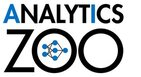
---

##### Copyright 2018 Analytics Zoo Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).


In [1]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


**Install Analytics Zoo**

You can install the latest pre-release version using `pip install --pre --upgrade analytics-zoo`. 

In [2]:
# Install latest pre-release version of Analytics Zoo 
# Installing Analytics Zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade analytics-zoo

Requirement already up-to-date: analytics-zoo in /usr/local/lib/python3.7/dist-packages (0.11.0b20210517)


In [3]:
# Install required dependencies
!pip install ray[tune]==1.2.0
!pip install xgboost==1.3.3

##  **This document explains how to use AutoXGBoost for regression**
Auto XGBoost is an automated classifier based on XGBoost, and it will automatically select the best hyperparameters for training within the specified parameter range.


## **Prepare dataset**

In [3]:
import os
if not os.path.exists('incd.csv'):
  !wget https://raw.githubusercontent.com/intel-analytics/analytics-zoo/master/pyzoo/zoo/examples/orca/automl/autoxgboost/incd.csv
  print('download completed.')
else:
  print('incd exists.')

incd exists.


In [4]:
import pandas as pd
df = pd.read_csv('./incd.csv', encoding='latin-1')
# specify the column of the classification
feature_cols = ["FIPS", "Lower 95% Confidence Interval", "Upper 95% Confidence Interval",
                "Average Annual Count", "Recent 5-Year Trend"]
target_col = "Age-Adjusted Incidence Rate"
X = df[feature_cols]
y = df[[target_col]]

In [5]:
df.head()

,County,FIPS,Age-Adjusted Incidence Rate,Lower 95% Confidence Interval,Upper 95% Confidence Interval,Average Annual Count,Recent Trend,Recent 5-Year Trend,Lower 95% Confidence Interval.1,Upper 95% Confidence Interval.1
0,"US (SEER+NPCR)(1,10)",0,62.4,62.3,62.6,214614,falling,-2.5,-3.0,-2.0
1,"Autauga County, Alabama(6,10)",1001,74.9,65.1,85.7,43,stable,0.5,-14.9,18.6
2,"Baldwin County, Alabama(6,10)",1003,66.9,62.4,71.7,170,stable,3.0,-10.2,18.3
3,"Barbour County, Alabama(6,10)",1005,74.6,61.8,89.4,25,stable,-6.4,-18.3,7.3
4,"Bibb County, Alabama(6,10)",1007,86.4,71.0,104.2,23,stable,-4.5,-31.4,32.9


In [6]:
# split train_set and test_set.
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

### **Init Orca Context** 

In [7]:
from zoo import init_spark_on_local,init_spark_on_yarn
from zoo.ray import RayContext
from zoo.orca import OrcaContext

Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /usr/local/lib/python3.7/dist-packages/zoo/share/conf/spark-analytics-zoo.conf to sys.path


This is the only place where you need to specify local or distributed mode. View [Orca Context](https://analytics-zoo.readthedocs.io/en/latest/doc/Orca/Overview/orca-context.html) for more details.

**Note**: You should export HADOOP_CONF_DIR=/path/to/hadoop/conf/dir when you run on Hadoop YARN cluster.

In [8]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

hadoop_conf = "local"

if hadoop_conf == 'yarn': # run on yarn clusters
    sc = init_spark_on_yarn(
        hadoop_conf=hadoop_conf,
        conda_name=conda_name, # "conda_name must be specified for yarn mode"
        num_executors=num_workers,
        executor_cores=executor_cores)
else: # run in local model
    sc = init_spark_on_local(cores="*")
ray_ctx = RayContext(sc=sc)
ray_ctx.init()

Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar:/usr/local/lib/python3.7/dist-packages/bigdl/share/lib/bigdl-0.12.2-jar-with-dependencies.jar pyspark-shell 
2021-05-17 06:16:48 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/lib/python3.7/dist-packages/zoo/share/lib/analytics-zoo-bigdl_0.12.2-spark_2.4.3-0.11.0-SNAPSHOT-jar-with-dependencies.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/local/lib/python3.7/dist-packages/pyspark/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).

User settings:

   KMP_AFFINITY=granularity=fine,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   OMP_NUM_THREADS=1

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128


cls.getname: com.intel.analytics.bigdl.python.api.Sample
BigDLBasePickler registering: bigdl.util.common  Sample
cls.getname: com.intel.analytics.bigdl.python.api.EvaluatedResult
BigDLBasePickler registering: bigdl.util.common  EvaluatedResult
cls.getname: com.intel.analytics.bigdl.python.api.JTensor
BigDLBasePickler registering: bigdl.util.common  JTensor
cls.getname: com.intel.analytics.bigdl.python.api.JActivity
BigDLBasePickler registering: bigdl.util.common  JActivity
Successfully got a SparkContext


2021-05-17 06:16:52,506	INFO services.py:1174 -- View the Ray dashboard at http://172.28.0.2:8265


{'node_ip_address': '172.28.0.2', 'raylet_ip_address': '172.28.0.2', 'redis_address': '172.28.0.2:6379', 'object_store_address': '/tmp/ray/session_2021-05-17_06-16-51_888476_7884/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-05-17_06-16-51_888476_7884/sockets/raylet', 'webui_url': '172.28.0.2:8265', 'session_dir': '/tmp/ray/session_2021-05-17_06-16-51_888476_7884', 'metrics_export_port': 58103, 'node_id': '9af80f70a7b55a0213099e10437934c6ad7f6458e0a5577a69177c79'}


{'metrics_export_port': 58103,
 'node_id': '9af80f70a7b55a0213099e10437934c6ad7f6458e0a5577a69177c79',
 'node_ip_address': '172.28.0.2',
 'object_store_address': '/tmp/ray/session_2021-05-17_06-16-51_888476_7884/sockets/plasma_store',
 'raylet_ip_address': '172.28.0.2',
 'raylet_socket_name': '/tmp/ray/session_2021-05-17_06-16-51_888476_7884/sockets/raylet',
 'redis_address': '172.28.0.2:6379',
 'session_dir': '/tmp/ray/session_2021-05-17_06-16-51_888476_7884',
 'webui_url': '172.28.0.2:8265'}

### **Create an AutoXGBRegressor**

*   AutoXGBRegressor is automated xgboost regressor.
  * logs_dir: Local directory to save logs and results.
  * n_jobs: Number of cpus for each trial. 
  * name: Name of the auto xgboost classifier.
  * xgb_configs: Note that we will directly use cpus_per_trial value for n_jobs in xgboost and you shouldn't specify n_jobs again.

In [9]:
from zoo.orca.automl.xgboost import AutoXGBRegressor
from zoo.orca.automl import hp

config = {'random_state': 2, # Random seed
          'min_child_weight': 3 # The smallest sample weight sum in the child nodes
        } 

# init an autoxgbregressor
auto_xgb_reg = AutoXGBRegressor(cpus_per_trial=2, name="auto_xgb_regressor", **config)

### **Fit with AutoXGBRegressor**

In [10]:
# params info
search_space_config = {
                      "n_estimators_range" : hp.grid_search([800,1000]), # Number of evaluators
                      "max_depth_range" : hp.grid_search([10,15]),  # Maximum depth of the tree
                      "lr" : hp.uniform(1e-4, 1e-1), # learning rate
                      "min_child_weight" : hp.choice([1, 2, 3])
                      } 


auto_xgb_reg.fit(data=(X_train, y_train), 
                validation_data=(X_val, y_val), 
                n_sampling=10, # the number of train 
                search_space=search_space_config,
                metric="rmse", # Evaluation function
                search_alg=None,
                search_alg_params=None,
                scheduler=None,
                scheduler_params=None)
print("Training completed.")

2021-05-17 06:19:10,131	INFO tune.py:450 -- Total run time: 133.44 seconds (133.34 seconds for the tuning loop).


Training completed.


### **Evaluate model resultst**

In [11]:
# get_best_model will return the best performing model
best_model = auto_xgb_reg.get_best_model()
# predict with the best trial
y_hat = best_model.predict(X_val)

In [12]:
# evaluate the resultst
rmse = best_model.evaluate(X_val, y_val, metrics=["rmse"])
# rmse is a list nested array type
print(f"Evaluate: the square root of mean square error is {rmse[0][0]:.2f}")

Evaluate: the square root of mean square error is 1.06


In [13]:
# stop sc and ray_ctx when your program finishes
ray_ctx.stop()
sc.stop()

In [ ]:
# Easy to debug and use, delete when the code is completed
os._exit(00)